# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of grapes and olives production in Italy 2006-2019
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2019. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
grapes_olives = pd.read_csv('./Italy_crop_data/grapes_olives.csv',skipinitialspace=True)
grapes_olives.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITE17,Pisa,HP_Q_EXT,harvested production - quintals,OLIVO,oil olives,2006,2006,125000.0,NaN,NaN
1,ITE17,Pisa,HP_Q_EXT,harvested production - quintals,OLIVO,oil olives,2007,2007,30702.0,NaN,NaN
2,ITE17,Pisa,HP_Q_EXT,harvested production - quintals,OLIVO,oil olives,2008,2008,145292.0,NaN,NaN
3,ITE17,Pisa,HP_Q_EXT,harvested production - quintals,OLIVO,oil olives,2009,2009,100000.0,NaN,NaN
4,ITE17,Pisa,HP_Q_EXT,harvested production - quintals,OLIVO,oil olives,2010,2010,95459.0,e,estimate data


## Pre-processing dataset 

In [3]:
# Drop Columns
grapes_olives = grapes_olives.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
grapes_olives

,Territory,Data type,Type of crop,Select time,Value
0,Pisa,harvested production - quintals,oil olives,2006,125000.0
1,Pisa,harvested production - quintals,oil olives,2007,30702.0
2,Pisa,harvested production - quintals,oil olives,2008,145292.0
3,Pisa,harvested production - quintals,oil olives,2009,100000.0
4,Pisa,harvested production - quintals,oil olives,2010,95459.0
...,...,...,...,...,...
17616,Valle d'Aosta / Vallée d'Aoste,production area - hectares,other olives,2021,1.0
17617,Valle d'Aosta / Vallée d'Aoste,total production - quintals,other olives,2021,40.0
17618,Valle d'Aosta / Vallée d'Aoste,harvested production - quintals,other olives,2021,40.0
17619,Milano,production area - hectares,other olives,2021,2.0


In [4]:
# Rename Columns
grapes_olives = grapes_olives.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
grapes_olives.Type_crop.unique()

array(['oil olives', 'Grapes for table use', 'olive oil', 'wine',
       'table olives',
       'grapes for wines with protected designation of origin (pdo)',
       'grapes for wines with protected geographical indication (pgi)',
       'grapes for other wines n.e.c. (without pdo/pgi)',
       'grapes for other purposes n.e.c.', 'grapes for raisins',
       'table winw', 'whithe wine', 'must', 'red and rosé wine',
       'registered designation of origin wine',
       'registered designation of origin white wine',
       'registered designation of origin black wine',
       'typical geographical indication wine',
       'typical geographical indication white wine',
       'typical geographical indication black wine', 'other olives'],
      dtype=object)

In [6]:
grapes_olives.Data_type.unique()

array(['harvested production - quintals ', 'total area - hectares',
       'yields production (percentage) ', 'total production - quintals ',
       'production area - hectares ', 'total production - hectoliters'],
      dtype=object)

In [7]:
grapes_olives = grapes_olives[grapes_olives["Year"] < 2020]

In [8]:
grapes_olives.Type_crop.unique()

array(['oil olives', 'Grapes for table use', 'olive oil', 'wine',
       'table olives'], dtype=object)

In [9]:
grapes_olives.Data_type.unique()

array(['harvested production - quintals ', 'total area - hectares',
       'yields production (percentage) ', 'total production - quintals ',
       'production area - hectares '], dtype=object)

In [10]:
grapes_olives.Year.unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2012])

In [11]:
def show_info(grapes_olives):
    print('DATASET SHAPE: ', grapes_olives.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(grapes_olives.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(grapes_olives.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(grapes_olives.isnull().sum())
show_info(grapes_olives)

DATASET SHAPE:  (10062, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10062 entries, 0 to 11374
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       10062 non-null  object 
 1   Data_type  10062 non-null  object 
 2   Type_crop  10062 non-null  object 
 3   Year       10062 non-null  int64  
 4   Value      10062 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 471.7+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          109
Data_type       5
Type_crop       5
Year           14
Value        4173
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing grapes and olives crop

In [12]:
#grapes_olives.City.unique()


## Select only values for total grapes and olives crop production - quintals


In [13]:
grapes_olives_prod = grapes_olives[grapes_olives['Data_type'] == 'total production - quintals ']
grapes_olives_prod.head()

,City,Data_type,Type_crop,Year,Value
60,Lucca,total production - quintals,wine,2006,54310.0
61,Lucca,total production - quintals,wine,2007,46900.0
62,Lucca,total production - quintals,wine,2008,45208.0
63,Lucca,total production - quintals,wine,2009,44900.0
64,Lucca,total production - quintals,wine,2010,34580.0


In [14]:
grapes_olives_prod['Value'] = grapes_olives_prod['Value']/10
grapes_olives_prod

,City,Data_type,Type_crop,Year,Value
60,Lucca,total production - quintals,wine,2006,5431.0
61,Lucca,total production - quintals,wine,2007,4690.0
62,Lucca,total production - quintals,wine,2008,4520.8
63,Lucca,total production - quintals,wine,2009,4490.0
64,Lucca,total production - quintals,wine,2010,3458.0
...,...,...,...,...,...
11353,Barletta-Andria-Trani,total production - quintals,olive oil,2018,18000.0
11354,Barletta-Andria-Trani,total production - quintals,olive oil,2019,18000.0
11367,Sud Sardegna,total production - quintals,olive oil,2017,1010.0
11368,Sud Sardegna,total production - quintals,olive oil,2018,1591.9


In [15]:
grapes_olives_prod = grapes_olives_prod.rename(columns = {'Value':'Total_production'})
grapes_olives_prod

,City,Data_type,Type_crop,Year,Total_production
60,Lucca,total production - quintals,wine,2006,5431.0
61,Lucca,total production - quintals,wine,2007,4690.0
62,Lucca,total production - quintals,wine,2008,4520.8
63,Lucca,total production - quintals,wine,2009,4490.0
64,Lucca,total production - quintals,wine,2010,3458.0
...,...,...,...,...,...
11353,Barletta-Andria-Trani,total production - quintals,olive oil,2018,18000.0
11354,Barletta-Andria-Trani,total production - quintals,olive oil,2019,18000.0
11367,Sud Sardegna,total production - quintals,olive oil,2017,1010.0
11368,Sud Sardegna,total production - quintals,olive oil,2018,1591.9


In [16]:
grapes_olives_prod = grapes_olives_prod.drop(columns =['Data_type'])
grapes_olives_prod

,City,Type_crop,Year,Total_production
60,Lucca,wine,2006,5431.0
61,Lucca,wine,2007,4690.0
62,Lucca,wine,2008,4520.8
63,Lucca,wine,2009,4490.0
64,Lucca,wine,2010,3458.0
...,...,...,...,...
11353,Barletta-Andria-Trani,olive oil,2018,18000.0
11354,Barletta-Andria-Trani,olive oil,2019,18000.0
11367,Sud Sardegna,olive oil,2017,1010.0
11368,Sud Sardegna,olive oil,2018,1591.9


## Total grapes and olives crop production in 2006-2019

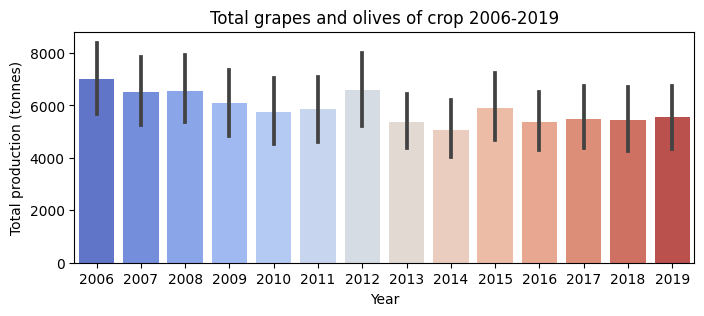

In [86]:
plt.figure(figsize= (8,3))
sns.barplot(x= 'Year', y= 'Total_production',data = grapes_olives_prod, palette='coolwarm')
plt.title('Total grapes and olives of crop 2006-2019')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes)')
plt.show()



## Grapes and olives crop production by Cities 

In [18]:
grapes_olives_prod_region = grapes_olives_prod.groupby(by = grapes_olives_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False)
grapes_olives_prod_region



,City,Total_production
92,Taranto,5806023.6
33,Foggia,5702488.3
7,Bari,5677752.8
97,Treviso,5035841.0
105,Verona,4300071.6
...,...,...
103,Verbano-Cusio-Ossola,2675.3
47,Lodi,2014.8
24,Como,1171.8
101,Varese,1093.7


In [19]:
region = grapes_olives_prod_region.nlargest(30, 'Total_production')

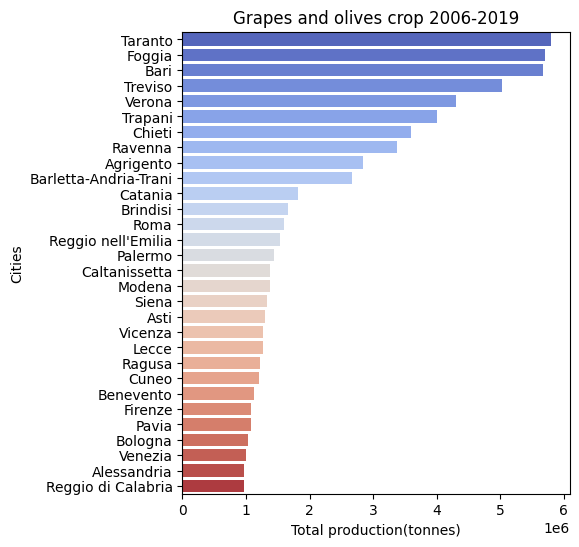

In [103]:
plt.figure(figsize= (5, 6))
sns.barplot(x= region['Total_production'],y= region['City'], orient='h', palette='coolwarm');
plt.title('Grapes and olives crop 2006-2019')
plt.xlabel('Total production(tonnes)')
plt.ylabel('Cities')
plt.show() 

##  Grapes and olives production  2006-2019

In [21]:
print(grapes_olives_prod.Type_crop.max())
print(grapes_olives_prod.Type_crop.value_counts())
print(grapes_olives_prod.Type_crop.nunique())



wine
wine                    1478
olive oil               1292
Grapes for table use     862
Name: Type_crop, dtype: int64
3


Dataset shows there are 10 different types of grapes and olives cultivated in Italy. The top most produced crops are :  Wine grapes, Table olives, Grapes for other wines, Grapes for table use ,Olive oil, Grapes for wines with protected designation of origin (pdo), Grapes for wines with protected geographical indication (pgi),Grapes for other wines n.e.c. (without pdo/pgi), Grapes for raisins, Grapes for other purposes n.e.c., Other olives,


In [22]:
grapes_olives_prod = grapes_olives_prod.replace('Grapes for table use','grapes-table')
grapes_olives_prod = grapes_olives_prod.replace('grapes for other purposes n.e.c.','grapes-n.e.c')
grapes_olives_prod = grapes_olives_prod.replace('grapes for raisins','grapes-raisins')
grapes_olives_prod = grapes_olives_prod.replace('grapes for other wines n.e.c. (without pdo/pgi)','grapes-wines(N-pdo/pgi)')
grapes_olives_prod = grapes_olives_prod.replace('grapes for wines with protected designation of origin (pdo)','grapes-wines(Y-pdo)')
grapes_olives_prod = grapes_olives_prod.replace('grapes for wines with protected geographical indication (pgi)','grapes-wines(Y-pgi)')

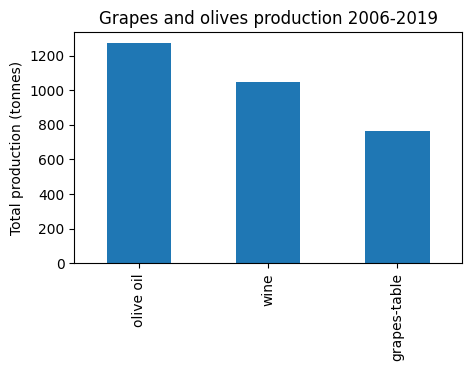

In [87]:
plt.figure(figsize=(5,3))
grapes_olives_prod ['Type_crop'].value_counts().plot.bar()
plt.title('Grapes and olives production 2006-2019')
plt.ylabel('Total production (tonnes)')
plt.show()


([0, 1, 2],
 [Text(0, 0, 'wine'), Text(1, 0, 'grapes-table'), Text(2, 0, 'olive oil')])

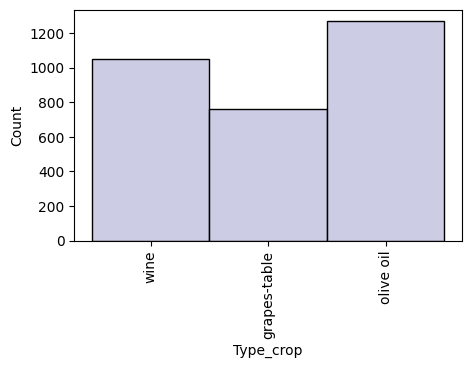

In [104]:
plt.figure(figsize=(5,3))
sns.histplot(grapes_olives_prod, x="Type_crop", color='#bcbddc')
plt.xticks(rotation = 90)

In [108]:
Q1 = grapes_olives_prod.quantile(0.25)
Q3 = grapes_olives_prod.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Year                   7.00
Total_production    3951.25
dtype: float64


In [109]:
# Remove outliers
grapes_olives_prod = grapes_olives_prod[~((grapes_olives_prod < (Q1 - 1.5 * IQR)) | (grapes_olives_prod > (Q3 + 1.5 * IQR))).any(axis=1)]
print(grapes_olives_prod.shape)

(2486, 4)


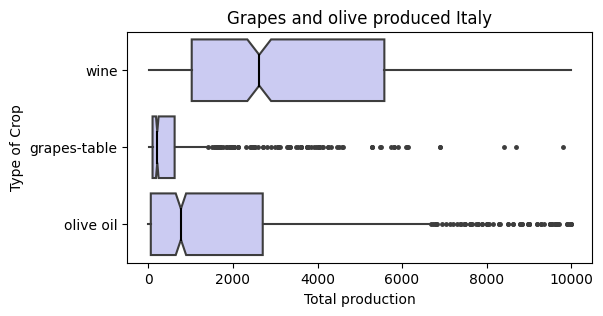

In [110]:
plt.figure(figsize=(6,3))

sns.boxplot(
    data=grapes_olives_prod, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.6, .6, .9, .5)},
    medianprops={"color": "black"},
)
plt.title('Grapes and olive produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

(0.0, 13062.722767972238)

<Figure size 500x300 with 0 Axes>

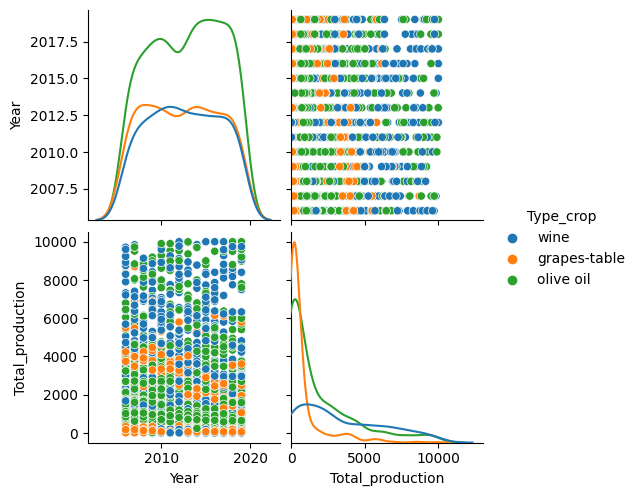

In [111]:
plt.figure(figsize=(5,3))
sns.pairplot(grapes_olives_prod, hue="Type_crop", diag_kws=dict(fill=False))
plt.xlim(0, None)

## Vizualization of ten type of grapes and olives produced in Italy in the period of 2006-2019 

<Figure size 500x300 with 0 Axes>

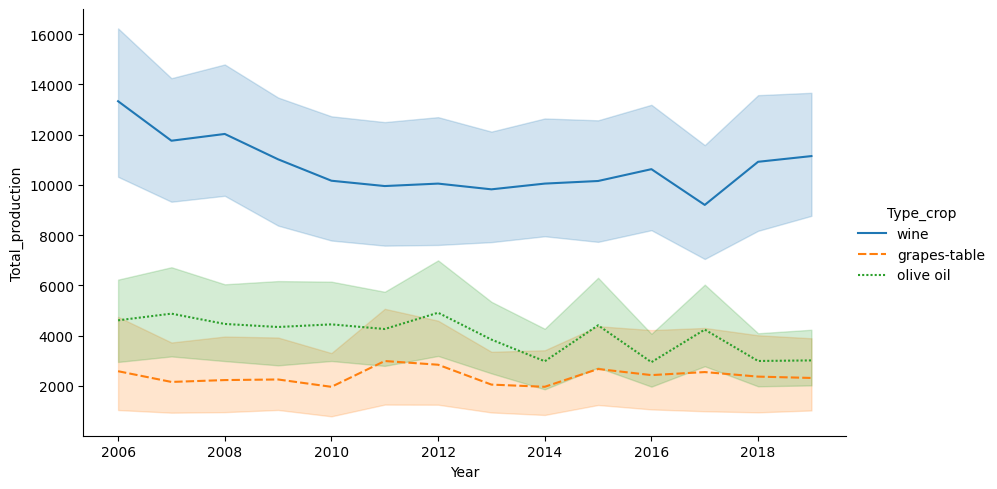

In [92]:
#Crop harvested by year
plt.figure(figsize=(5,3))
plotcrop = sns.relplot(kind='line', data=grapes_olives_prod, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


### Create columns for each type crop 

In [30]:
# Create columns for each type crop
grapes_olives_pivot = grapes_olives_prod.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Total_production'])
grapes_olives_pivot

Total_production                   
Type_crop          grapes-table olive oil     wine
City      Year                                    
Agrigento 2006              NaN    9287.0      NaN
          2007              NaN    9510.0      NaN
          2008              NaN   10640.0      NaN
          2009              NaN    8300.0      NaN
          2010              NaN    7600.0      NaN
...                         ...       ...      ...
Viterbo   2015              NaN    4500.0  15300.0
          2016              NaN    4400.0  15100.0
          2017              NaN    1700.0   8105.0
          2018              NaN    1900.0   8180.0
          2019            104.0    2150.0  14776.0

[1460 rows x 3 columns]

In [31]:
# Drop level
grapes_olives_pivot.columns = grapes_olives_pivot.columns.droplevel()
grapes_olives_pivot

Type_crop       grapes-table  olive oil     wine
City      Year                                  
Agrigento 2006           NaN     9287.0      NaN
          2007           NaN     9510.0      NaN
          2008           NaN    10640.0      NaN
          2009           NaN     8300.0      NaN
          2010           NaN     7600.0      NaN
...                      ...        ...      ...
Viterbo   2015           NaN     4500.0  15300.0
          2016           NaN     4400.0  15100.0
          2017           NaN     1700.0   8105.0
          2018           NaN     1900.0   8180.0
          2019         104.0     2150.0  14776.0

[1460 rows x 3 columns]

In [32]:
grapes_olives_pivot = grapes_olives_pivot.fillna(0)
grapes_olives_pivot

Type_crop       grapes-table  olive oil     wine
City      Year                                  
Agrigento 2006           0.0     9287.0      0.0
          2007           0.0     9510.0      0.0
          2008           0.0    10640.0      0.0
          2009           0.0     8300.0      0.0
          2010           0.0     7600.0      0.0
...                      ...        ...      ...
Viterbo   2015           0.0     4500.0  15300.0
          2016           0.0     4400.0  15100.0
          2017           0.0     1700.0   8105.0
          2018           0.0     1900.0   8180.0
          2019         104.0     2150.0  14776.0

[1460 rows x 3 columns]

In [33]:
#Rename index
grapes_olives_pivot = grapes_olives_pivot.rename_axis(None,axis=1)
grapes_olives_pivot

grapes-table  olive oil     wine
City      Year                                  
Agrigento 2006           0.0     9287.0      0.0
          2007           0.0     9510.0      0.0
          2008           0.0    10640.0      0.0
          2009           0.0     8300.0      0.0
          2010           0.0     7600.0      0.0
...                      ...        ...      ...
Viterbo   2015           0.0     4500.0  15300.0
          2016           0.0     4400.0  15100.0
          2017           0.0     1700.0   8105.0
          2018           0.0     1900.0   8180.0
          2019         104.0     2150.0  14776.0

[1460 rows x 3 columns]

In [34]:
# Reset index
grapes_olives_pivot = grapes_olives_pivot.reset_index()
grapes_olives_pivot

,City,Year,grapes-table,olive oil,wine
0,Agrigento,2006,0.0,9287.0,0.0
1,Agrigento,2007,0.0,9510.0,0.0
2,Agrigento,2008,0.0,10640.0,0.0
3,Agrigento,2009,0.0,8300.0,0.0
4,Agrigento,2010,0.0,7600.0,0.0
...,...,...,...,...,...
1455,Viterbo,2015,0.0,4500.0,15300.0
1456,Viterbo,2016,0.0,4400.0,15100.0
1457,Viterbo,2017,0.0,1700.0,8105.0
1458,Viterbo,2018,0.0,1900.0,8180.0


## Statistical analysis

In [35]:
grapes_olives_pivot.describe()

,Year,grapes-table,olive oil,wine
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,2012.601370,1236.743425,3456.244041,7695.024315
std,3.988331,4347.831745,6991.197745,10636.622509
min,2006.000000,0.000000,0.000000,0.000000
25%,2009.000000,0.000000,4.600000,0.000000
50%,2013.000000,18.000000,666.000000,2554.300000
75%,2016.000000,285.000000,3285.650000,11421.875000
max,2019.000000,40000.000000,43000.000000,43009.000000


#### Data metrics : skew, kurtosis and mode

In [36]:
grapes_olives_pivot_stats = grapes_olives_pivot[['olive oil', 'wine','grapes-table']]
print(grapes_olives_pivot_stats.astype(float).skew())
print(grapes_olives_pivot_stats.astype(float).kurtosis())
print(grapes_olives_pivot_stats.astype(float).mode())

olive oil       3.147289
wine            1.573590
grapes-table    4.908046
dtype: float64
olive oil       10.287546
wine             1.533735
grapes-table    26.120121
dtype: float64
   olive oil  wine  grapes-table
0        0.0   0.0           0.0


## Graphs

#### Histogram and Boxplot showing data distribuion and outliers¶
 
Normalizing the dataset

The data need to be normalized for further use in a modelling. Here the data will be normalize by deleting outliers using the interquartile range (IQR).

Calculate and print the interquartile range

In [47]:
Q1 = grapes_olives_pivot_stats.quantile(0.25)
Q3 = grapes_olives_pivot_stats.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


olive oil        3281.050
wine            11421.875
grapes-table      285.000
dtype: float64


### Remove outliers and plot graphs

In [48]:
# Remove outliers
grapes_olives_pivot_stats[~((grapes_olives_pivot < (Q1 - 1.5 * IQR)) | (grapes_olives_pivot_stats > (Q3 + 1.5 * IQR))).any(axis=1)]
print(grapes_olives_pivot_stats.shape)

(1460, 3)


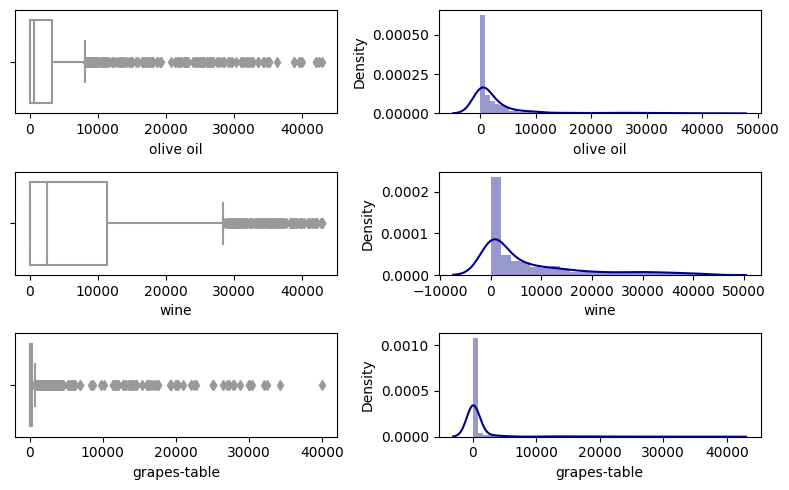

In [82]:
fig, ax = plt.subplots(3, 2, figsize = (8, 5))

sns.boxplot(x= grapes_olives_pivot_stats["olive oil"], color = 'white', ax = ax[0,0])
sns.distplot(grapes_olives_pivot_stats['olive oil'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= grapes_olives_pivot_stats["wine"],color = 'white', ax = ax[1,0])
sns.distplot(grapes_olives_pivot_stats['wine'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= grapes_olives_pivot_stats["grapes-table"],color = 'white', ax = ax[2,0])
sns.distplot(grapes_olives_pivot_stats['grapes-table'], color = 'darkblue',ax = ax[2,1])

plt.tight_layout()

### Pre-processing ferlizers dataset
fertilizers distributed - tonnes

In [50]:
fertilizer = pd.read_csv('fertilizer_by_prov.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2006,2006,1227,NaN,NaN
1,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2007,2007,1812,NaN,NaN
2,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2008,2008,5224,NaN,NaN
3,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2009,2009,2051,NaN,NaN
4,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2010,2010,54,NaN,NaN


In [51]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags'])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [52]:
# change name of columns
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [53]:
fertilizer = fertilizer[fertilizer["Year"] < 2020]

In [54]:
fertilizer.City.unique()

array(['Torino', 'Vercelli', 'Biella', 'Verbano-Cusio-Ossola', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', "Valle d'Aosta / Vallée d'Aoste",
       'Imperia', 'Savona', 'Genova', 'La Spezia', 'Varese', 'Como',
       'Lecco', 'Sondrio', 'Milano', 'Bergamo', 'Brescia', 'Pavia',
       'Lodi', 'Cremona', 'Mantova', 'Trentino Alto Adige / Südtirol',
       'Provincia Autonoma Bolzano / Bozen', 'Provincia Autonoma Trento',
       'Verona', 'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova',
       'Rovigo', 'Pordenone', 'Udine', 'Gorizia', 'Trieste', 'Piacenza',
       'Parma', "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara',
       'Ravenna', 'Forlì-Cesena', 'Rimini', 'Massa-Carrara', 'Lucca',
       'Pistoia', 'Firenze', 'Prato', 'Livorno', 'Pisa', 'Arezzo',
       'Siena', 'Grosseto', 'Perugia', 'Terni', 'Pesaro e Urbino',
       'Ancona', 'Macerata', 'Ascoli Piceno', 'Viterbo', 'Rieti', 'Roma',
       'Latina', 'Frosinone', "L'Aquila", 'Teramo', 'Pescara', 'Chieti',
       

In [55]:
fertilizer.Data_type.unique()

array(['fertilizers distributed - quintals',
       'fertilizers distributed - tonnes'], dtype=object)

In [56]:
#convert quintals to tonnes
fertilizer.loc[fertilizer['Data_type'] == 'fertilizers distributed - quintals','Fertilizers_tonnes' ] = fertilizer['Fertilizers_tonnes'] / 10


In [57]:
# drop column 
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,122.7
1,Torino,calcium cyanamide,2007,181.2
2,Torino,calcium cyanamide,2008,522.4
3,Torino,calcium cyanamide,2009,205.1
4,Torino,calcium cyanamide,2010,5.4
...,...,...,...,...
68377,Sud Sardegna,specific action products -,2018,174.0
68378,Sud Sardegna,specific action products -,2019,41.0
68381,Sud Sardegna,specific action products -,2017,335.0
68382,Sud Sardegna,specific action products -,2018,137.0


In [58]:
fertilizer.Type_fertilizer.unique()

array(['calcium cyanamide', 'nitrates ', 'ammonium sulphate', 'urea',
       'other fertilizers different from calcium cyanamide, nitrates, ammonium sulphate, urea',
       'simple superphosphate', 'triple superphosphate',
       'other fertilizers different from simple superphosphate and triple superphosphate',
       'sulphate', 'chloride ',
       'other fertilizers different from sulphate and chloride ',
       'two components - nitrogen-phosphorous',
       'two components - phosphorus-potassium',
       'two components - nitrogen-potassium',
       'three components - nitrogen-phosphorous-phosphorous',
       'containing only one secondary macronutrient - calcium oxide',
       'containing only one secondary macronutrient - magnesium oxide',
       'containing only one secondary macronutrient - sulphur oxide',
       'containing only one secondary macronutrient',
       'containing micronutrients containing only a micronutrient in mineral form',
       'containing micronutrients 

In [59]:
fertilizer.Year.unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019])

### Selecting fertilizers for future analysis 

In [60]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())
print(fertilizer.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               3065
three components - nitrogen-phosphorous-phosphorous                                      1701
containing only one secondary macronutrient - magnesium oxide                            1533
soil correctives - other  soil correctives                                               1533
other soil amendments                                                                    1533
peaty soil amendment                                                                     1533
mixed soil amendment                                                                     1533
vegetable soil amendment                                                                 1533
organic-mineral fertilizers - compound                                                   1533
organic-mineral fertilizers - straight nitrogen                                          1533
organic fertilizers - compound     

In [61]:
# Rename name of fertilizers 
fertilizer = fertilizer.replace('organic fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - compound','organic-mineral')
fertilizer = fertilizer.replace('organic fertilizers - compound','organic')
fertilizer = fertilizer.replace('mixed soil amendment','mix-amend')
fertilizer = fertilizer.replace('peaty soil amendment','peaty-amend')
fertilizer = fertilizer.replace('peaty amendment','peaty-amend')
fertilizer = fertilizer.replace('peat amendment','peaty-amend')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - nitrogen-potassium','nitrogen-potassium')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - phosphorus-potassium','phosphorus-potassium')
fertilizer = fertilizer.replace('vegetable soil amendment', 'organic')

In [62]:
fertilizer = fertilizer.apply(lambda row: row[fertilizer['Type_fertilizer'].isin(['organic', 'nitrogen-potassium','nitrogen-phosphorous'])])

fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
88,Torino,nitrogen-phosphorous,2006,13448.7
89,Torino,nitrogen-phosphorous,2007,15689.3
90,Torino,nitrogen-phosphorous,2008,8672.4
91,Torino,nitrogen-phosphorous,2009,7766.9
92,Torino,nitrogen-phosphorous,2010,9253.3


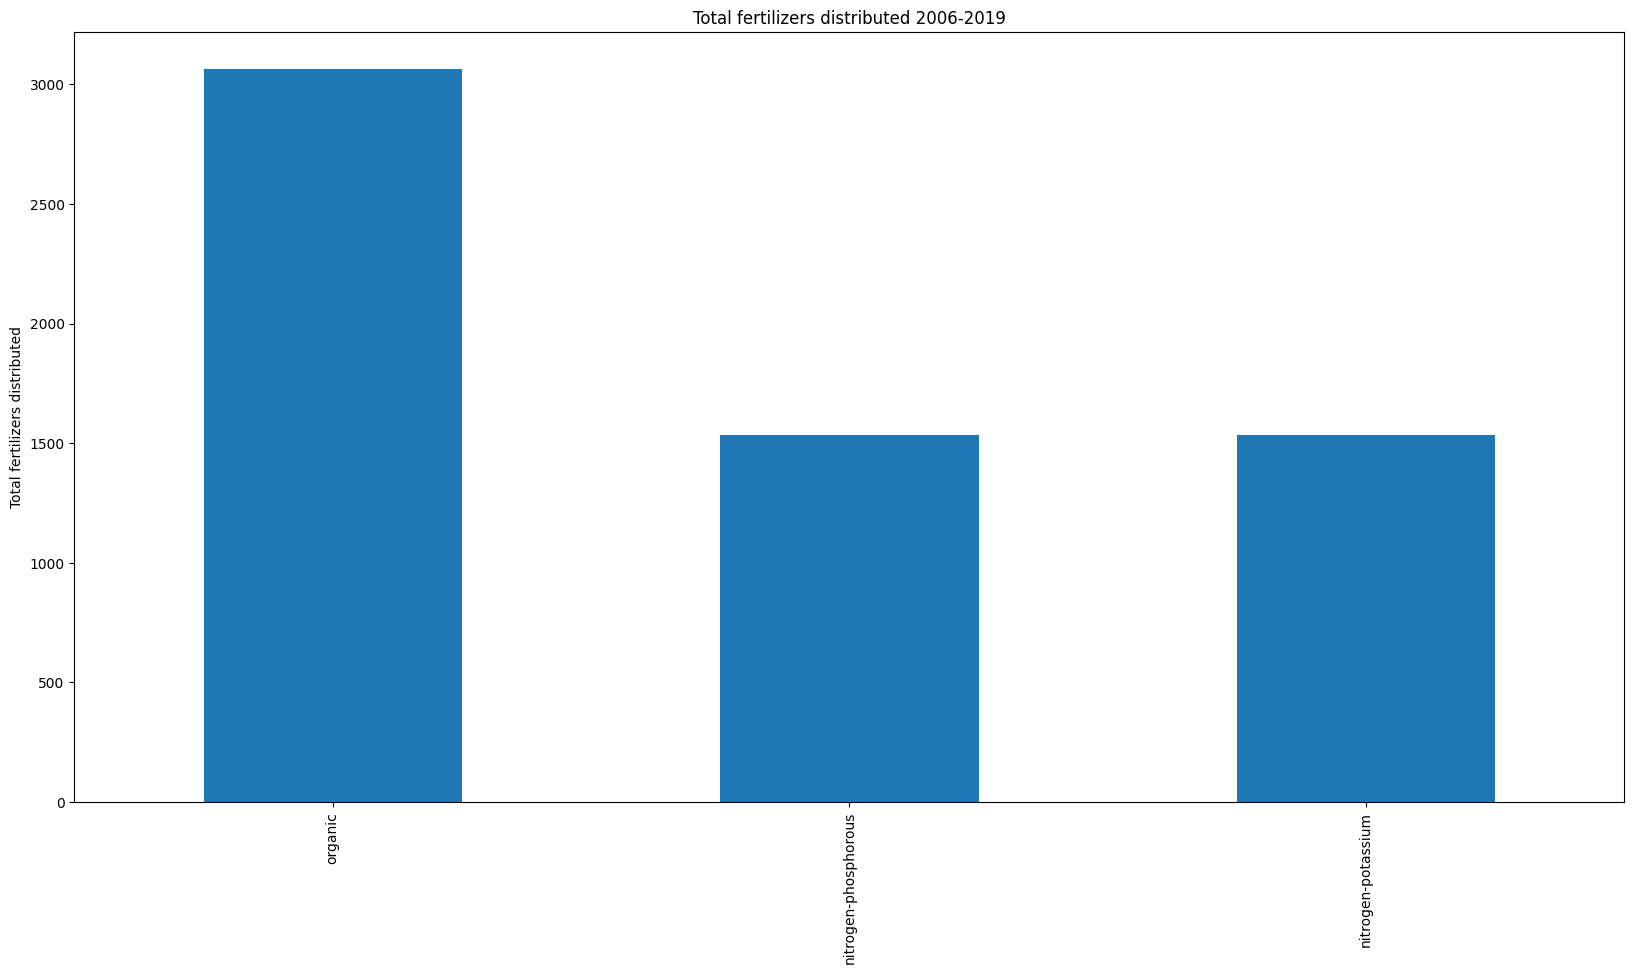

In [63]:
plt.figure(figsize=(20,10))
fertilizer['Type_fertilizer'].value_counts().plot.bar()
plt.title('Total fertilizers distributed 2006-2019')
plt.ylabel('Total fertilizers distributed')
plt.show()

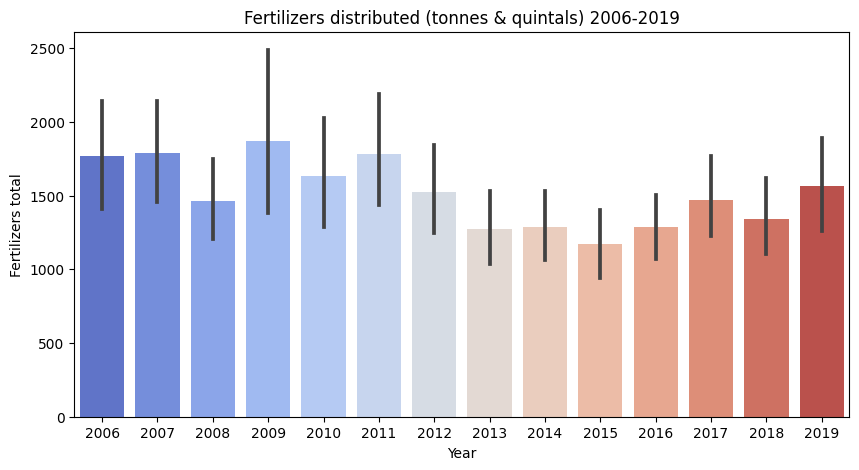

In [64]:
# fertilizer distributed tonnes and quintals
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Fertilizers_tonnes',data = fertilizer, palette='coolwarm')
plt.title('Fertilizers distributed (tonnes & quintals) 2006-2019')
plt.xlabel('Year')
plt.ylabel('Fertilizers total')
plt.show()


In [65]:
fertilizer20 = fertilizer.nlargest(20, 'Fertilizers_tonnes')

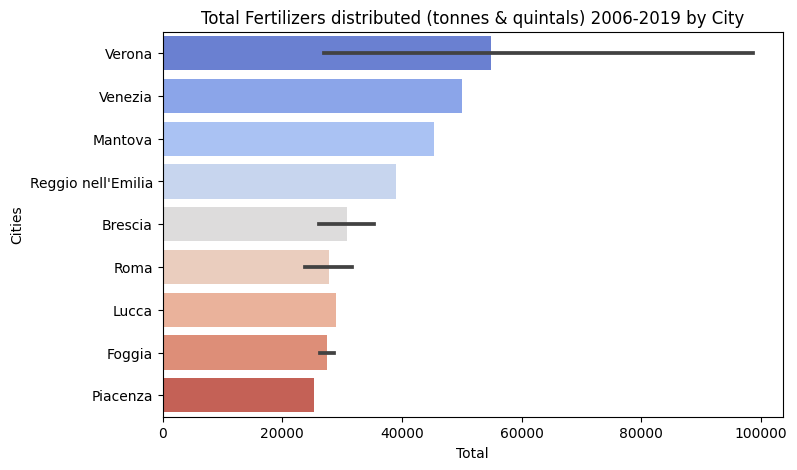

In [66]:
fertilizer20 = fertilizer20.sort_values('Fertilizers_tonnes',ascending=False)

plt.figure(figsize= (8,5))
sns.barplot(x=fertilizer20['Fertilizers_tonnes'] ,y= fertilizer20 ['City'], palette='coolwarm');
plt.title('Total Fertilizers distributed (tonnes & quintals) 2006-2019 by City')
plt.xlabel('Total')
plt.ylabel('Cities')
plt.show()

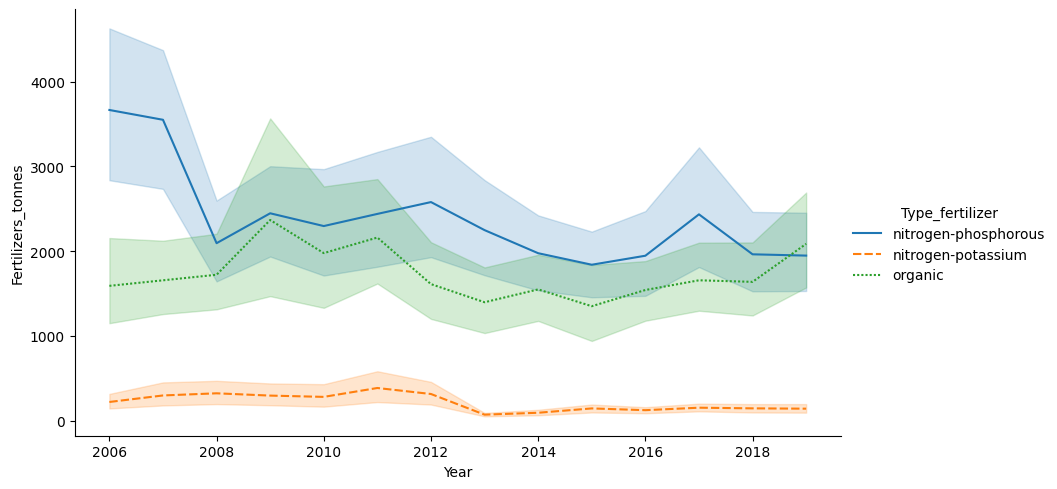

In [67]:
#Fertilizers distributed by year

fertilizer_plot = sns.relplot(kind='line', data=fertilizer, x='Year', y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)


In [68]:
fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
88,Torino,nitrogen-phosphorous,2006,13448.7
89,Torino,nitrogen-phosphorous,2007,15689.3
90,Torino,nitrogen-phosphorous,2008,8672.4
91,Torino,nitrogen-phosphorous,2009,7766.9
92,Torino,nitrogen-phosphorous,2010,9253.3


### Create new dataframe with the selected type of fertilizers as columns


In [69]:
# Create columns for each type of fertilizer 
fertilizer_pivot = fertilizer.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer_pivot

Fertilizers_tonnes                           
Type_fertilizer nitrogen-phosphorous nitrogen-potassium organic
City      Year                                                 
Agrigento 2006                 497.7               27.7  3143.9
          2007                 649.8               49.1  3534.8
          2008                 521.3               61.4  3750.4
          2009                 380.8               46.8  2791.4
          2010                 327.1               44.0  2346.0
...                              ...                ...     ...
Viterbo   2015                8212.0                7.0  1425.0
          2016                5360.0               41.0  1613.0
          2017                4732.0               66.0  1760.0
          2018                4376.0               19.0  1591.0
          2019                3964.0              195.0  1251.0

[1533 rows x 3 columns]

In [70]:
# Drop level
fertilizer_pivot.columns = fertilizer_pivot.columns.droplevel()
fertilizer_pivot

Type_fertilizer  nitrogen-phosphorous  nitrogen-potassium  organic
City      Year                                                    
Agrigento 2006                  497.7                27.7   3143.9
          2007                  649.8                49.1   3534.8
          2008                  521.3                61.4   3750.4
          2009                  380.8                46.8   2791.4
          2010                  327.1                44.0   2346.0
...                               ...                 ...      ...
Viterbo   2015                 8212.0                 7.0   1425.0
          2016                 5360.0                41.0   1613.0
          2017                 4732.0                66.0   1760.0
          2018                 4376.0                19.0   1591.0
          2019                 3964.0               195.0   1251.0

[1533 rows x 3 columns]

In [71]:
#Rename index
fertilizer_pivot = fertilizer_pivot.rename_axis(None,axis=1)
fertilizer_pivot

nitrogen-phosphorous  nitrogen-potassium  organic
City      Year                                                   
Agrigento 2006                 497.7                27.7   3143.9
          2007                 649.8                49.1   3534.8
          2008                 521.3                61.4   3750.4
          2009                 380.8                46.8   2791.4
          2010                 327.1                44.0   2346.0
...                              ...                 ...      ...
Viterbo   2015                8212.0                 7.0   1425.0
          2016                5360.0                41.0   1613.0
          2017                4732.0                66.0   1760.0
          2018                4376.0                19.0   1591.0
          2019                3964.0               195.0   1251.0

[1533 rows x 3 columns]

In [72]:
# Reset index
fertilizer_pivot = fertilizer_pivot.reset_index()
fertilizer_pivot

,City,Year,nitrogen-phosphorous,nitrogen-potassium,organic
0,Agrigento,2006,497.7,27.7,3143.9
1,Agrigento,2007,649.8,49.1,3534.8
2,Agrigento,2008,521.3,61.4,3750.4
3,Agrigento,2009,380.8,46.8,2791.4
4,Agrigento,2010,327.1,44.0,2346.0
...,...,...,...,...,...
1528,Viterbo,2015,8212.0,7.0,1425.0
1529,Viterbo,2016,5360.0,41.0,1613.0
1530,Viterbo,2017,4732.0,66.0,1760.0
1531,Viterbo,2018,4376.0,19.0,1591.0


#### Join crop and fertilizers datasets

In [73]:
# Join both datasets 
it_crop_ferlizer = pd.merge(grapes_olives_pivot, fertilizer_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_ferlizer

,City,Year,grapes-table,olive oil,wine,nitrogen-phosphorous,nitrogen-potassium,organic
0,Agrigento,2006,0.0,9287.0,0.0,497.7,27.7,3143.9
1,Agrigento,2007,0.0,9510.0,0.0,649.8,49.1,3534.8
2,Agrigento,2008,0.0,10640.0,0.0,521.3,61.4,3750.4
3,Agrigento,2009,0.0,8300.0,0.0,380.8,46.8,2791.4
4,Agrigento,2010,0.0,7600.0,0.0,327.1,44.0,2346.0
...,...,...,...,...,...,...,...,...
1455,Viterbo,2015,0.0,4500.0,15300.0,8212.0,7.0,1425.0
1456,Viterbo,2016,0.0,4400.0,15100.0,5360.0,41.0,1613.0
1457,Viterbo,2017,0.0,1700.0,8105.0,4732.0,66.0,1760.0
1458,Viterbo,2018,0.0,1900.0,8180.0,4376.0,19.0,1591.0


### Correlation 


In [74]:

crop = it_crop_ferlizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes


cor_selected = it_crop_ferlizer[['olive oil', 'wine','grapes-table','organic',
                                 'nitrogen-potassium','nitrogen-phosphorous']]


<AxesSubplot: title={'center': 'Correlation'}>

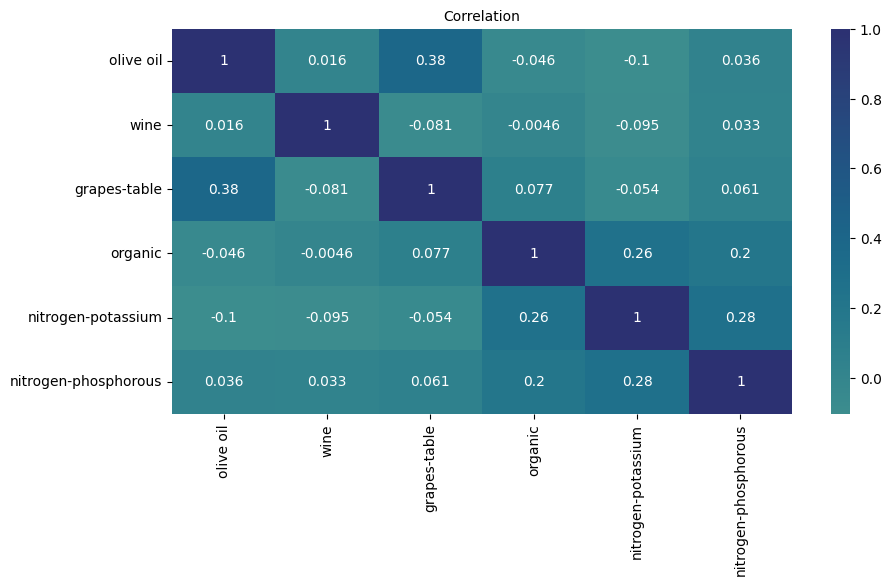

In [81]:
plt.figure(figsize=(10,5))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of grapes and olives production in Italy 

* Wine medium correlation with nitrogen-phosphorous

* Olive oil has hight correlation with midium correlation with grapes-tables.



### Calculating Variance Inflation Factor (VIF) for all given features

In [76]:
# Function to compute the VIF
def compute_vif(selected_features):
    
    y = cor_selected [selected_features]
    # the calculation of variance inflation requires a constant
    y['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Feature"] = y.columns
    vif["VIF"] = [variance_inflation_factor(y.values, i) for i in range(y.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [77]:
# Features selection
selected_features = ['olive oil', 'wine','grapes-table','organic',
                                 'nitrogen-potassium','nitrogen-phosphorous']

# compute vif 
compute_vif(selected_features).sort_values('VIF', ascending=False)


,Feature,VIF
2,grapes-table,1.203435
0,olive oil,1.192854
4,nitrogen-potassium,1.172187
5,nitrogen-phosphorous,1.119167
3,organic,1.105372
1,wine,1.024088


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html